In [32]:
import geopandas as gpd                 # geodataframes
# import pandas as pd
# import json
# from shapely import wkt
# from shapely.geometry import shape
# from urllib.parse import urlencode

from shapely.geometry import Point      # for buffer analysis
import matplotlib.pyplot as plt         # mapping
import pytidycensus as tc               # census helper


In [33]:
'''
Get Borough Boundaries (API)
'''
borough_url = "https://data.cityofnewyork.us/resource/gthc-hcne.geojson" # ABOUT: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/gthc-hcne/about_data
borough_gdf = gpd.read_file(borough_url)

# Create new geodataframe using filter
bk_gdf = borough_gdf[borough_gdf["boroname"]=="Brooklyn"]
qn_gdf = borough_gdf[borough_gdf["boroname"]=="Queens"]

In [34]:
'''
Get IBX ROW & Stations (local file)
'''
ibx_path = r"C:\Users\orinj\Documents\Urban Planning\GIS Data\IBX\IBX.gdb"

# Find layers in geodatabase file
layers = gpd.list_layers(ibx_path)
layer_names = layers['name'].to_list()

# Store each layer as a geodataframe in a dictionary with index as name
geodataframes = {}
for name in layer_names:
    geodataframes[name] = gpd.read_file(ibx_path, layer=name)

# Save each layer as a named geodataframe
ibx_gdf = geodataframes['IBX_Rail_Line']
stations_gdf = geodataframes['stations']

## How to find new census variables
1. Go to this site to find census API variable codes: https://api.census.gov/data.html
2. Search for "ACS 5-Year Detailed Tables"


In [35]:
'''
Get census tract data (API)
'''

# Set census API key
tc.set_census_api_key("2860f2844d671bd10d3eceb44c50bb4da851972a")

census_vars = [
"B19013_001E",          # Median household income
"B08301_001E",          # Means of transportation to work: Total estimates (age 16+)
"B08301_002E",          # Means of transportation to work: Car, truck, or van (age 16+)
"B08201_001E",          # Percent of households with no car (inverse is percent with one or more car)
]

counties = ["Kings", "Queens"]

# Get ACS data
acs_gdf = tc.get_acs(
    variables=census_vars,
    geography="block group",
    state="NY",
    county=counties,
    year=2023,
    output="wide",
    geometry=True  # Get geometry
)
print(acs_gdf.columns)

Census API key has been set for this session.
Getting data from the 2019-2023 5-year ACS
Index(['GEOID', 'geometry', 'B19013_001E', 'B08301_001E', 'B08301_002E',
       'B08201_001E', 'state', 'county', 'tract', 'block group', 'NAME',
       'B19013_001_moe', 'B08301_001_moe', 'B08301_002_moe', 'B08201_001_moe'],
      dtype='object')


In [36]:
'''
Create subset geodataframes
'''
# Create means of transportation to work gdf
transportation_gdf = acs_gdf[['GEOID','geometry','B08301_001E','B08301_002E']].copy()
# Calculate percent of total commuters use car
transportation_gdf['percent_car'] = transportation_gdf['B08301_002E'] / transportation_gdf['B08301_001E'] * 100

mhi_gdf = acs_gdf[['GEOID','geometry','B19013_001E']].copy()
mhi_gdf["mhi"] = mhi_gdf["B19013_001E"]

In [37]:
'''
Reproject CRS
'''
# reproject to projected CRS local to NY
bk_gdf_2263 = bk_gdf.to_crs(epsg=2263)  # NY State Plane (feet)
qn_gdf_2263 = qn_gdf.to_crs(epsg=2263)
ibx_gdf_2263 = ibx_gdf.to_crs(epsg=2263)
stations_gdf_2263 = stations_gdf.to_crs(epsg=2263)

mhi_gdf_2263 = mhi_gdf.to_crs(epsg=2263)  # NY State Plane (feet)
transportation_gdf_2263 = transportation_gdf.to_crs(epsg=2263)


In [38]:
'''
Create buffers and filter data

- half mile walkshed radius (buffers)
- include all block groups with centroid within radius/buffer

'''

# Create station buffers
buffer_radius = 5280/2  # half mile radius
stations_gdf_2263['buffer'] = stations_gdf_2263.geometry.buffer(buffer_radius)  # add buffer column with data for each station

# combine buffers into one geometry
from shapely.ops import unary_union
all_buffers = unary_union(stations_gdf_2263['buffer'])

# Add centroid data to block groups
transportation_gdf_2263['centroid'] = transportation_gdf_2263.geometry.centroid
mhi_gdf_2263['centroid'] = mhi_gdf_2263.geometry.centroid

# Find block groups with centroid within buffer radius
transpo_walkshed_bgs = transportation_gdf_2263[transportation_gdf_2263['centroid'].within(all_buffers)]
mhi_walkshed_bgs = mhi_gdf_2263[mhi_gdf_2263['centroid'].within(all_buffers)]


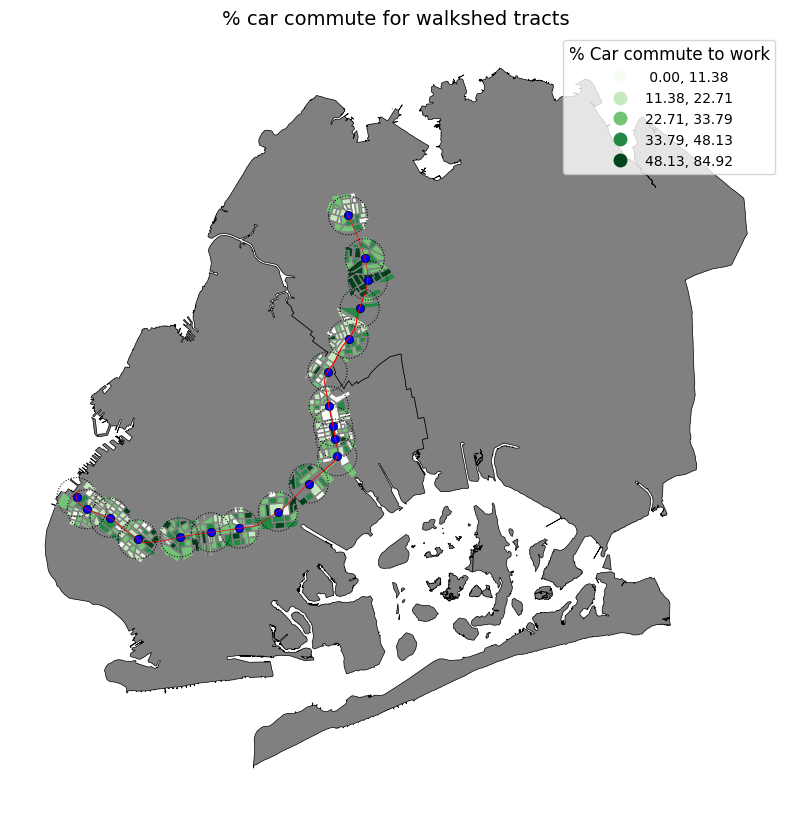

In [ ]:
''' 
Plot % car commute for walkshed block groups
'''
# Set up plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot geodataframes
bk_gdf_2263.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.5)
qn_gdf_2263.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.5)
transpo_walkshed_bgs.plot(
    ax=ax,
    column="percent_car",
    cmap="Greens",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="grey",
    legend=True,
    # categorical=True,
    legend_kwds={
        "title": "% Car commute to work",
        "loc": "upper right",
        "fontsize": 10,
        "title_fontsize": 12
    }
)
ibx_gdf_2263.plot(ax=ax, color="red", edgecolor="black", linewidth=0.5)
stations_gdf_2263['buffer'].plot(ax=ax, color="none", edgecolor="black", linewidth=.75, linestyle=':')
stations_gdf_2263.plot(ax=ax, color="blue", edgecolor="black", linewidth=0.5)

ax.set_title("% car commute for walkshed block groups", fontsize=14)
ax.set_axis_off()   # remove axes
plt.show()


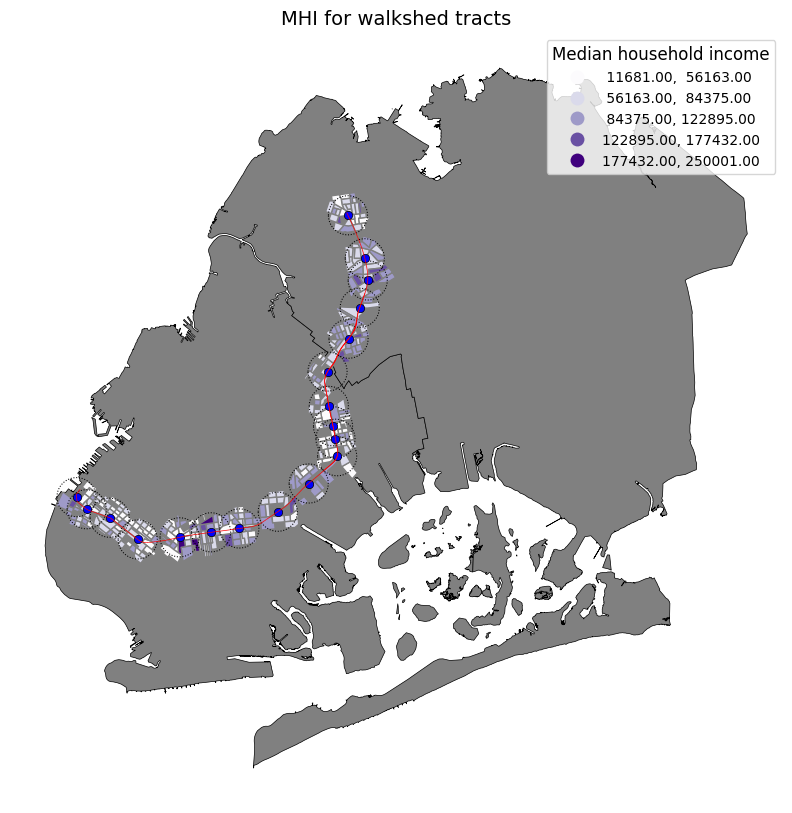

In [ ]:
''' 
Plot MHI for walkshed block groups
'''
# Set up plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot geodataframes
bk_gdf_2263.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.5)
qn_gdf_2263.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.5)
mhi_walkshed_bgs.plot(
    ax=ax,
    column="mhi",
    cmap="Purples",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="grey",
    legend=True,
    # categorical=True,
    legend_kwds={
        "title": "Median household income",
        "loc": "upper right",
        "fontsize": 10,
        "title_fontsize": 12
    }
)
ibx_gdf_2263.plot(ax=ax, color="red", edgecolor="black", linewidth=0.5)
stations_gdf_2263['buffer'].plot(ax=ax, color="none", edgecolor="black", linewidth=.75, linestyle=':')
stations_gdf_2263.plot(ax=ax, color="blue", edgecolor="black", linewidth=0.5)

ax.set_title("MHI for walkshed block groups", fontsize=14)
ax.set_axis_off()   # remove axes
plt.show()
